
# **EJERCICIO PRÁCTICO - ANALÍTICA EN SALUD: CANTIDAD DE CIRUGÍAS**

# Carga de datos y paquetes

Generacion de base de datos post pandemia a trabajar (2021-2022)

In [ ]:
#Conexión con colab
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from unicodedata import normalize
from sklearn.model_selection import RandomizedSearchCV
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos
from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leer cada una de las bases de datos depuradas anteriormente.
cx = pd.read_csv('/content/drive/MyDrive/CursoAnalitica3/AplicacionesEnSalud/cxpost (1).csv')
cronicos = pd.read_csv('/content/drive/MyDrive/CursoAnalitica3/AplicacionesEnSalud/cronicospost.csv')
usuarios = pd.read_csv('/content/drive/MyDrive/CursoAnalitica3/AplicacionesEnSalud/usuariospost.csv')

In [ ]:
# Observar los primeros 3 datos de la BD de cirugías
cx.head(3)

,Unnamed: 0,YEAR,MES,CODIGO SERVICIO HABILITACION,SERVICIO HABILITACION,TIPO IDENTIFICACION,NRODOC,FECHA NACIMIENTO,REGIMEN,CODIGO EPS,...,COD DIAGNOSTICO POSTQUIRURGICO,DIAGNOSTICO POSTQUIRURGICO,TIPO DE HERIDA,TIPO AISLAMIENTO,COMPLICACIONES,CATEGORIA COMPLICACION,ESPECIALIDAD,SEDE,IDCX,ADMISION
0,854,2021,ENERO,207.0,cirugia ortopedica,CC,308384,1971-02-10,subsidiado,1415.0,...,T818,OTRAS COMPLICACIONES DE PROCEDIMIENTOS NO CLAS...,contaminada,NaN,False,3.0,ortopedia,LEON XIII,109718.0,5466001
1,855,2021,ENERO,215.0,cirugia urologica,CC,308384,1971-02-10,subsidiado,1415.0,...,N359,ESTRECHEZ URETRAL NO ESPECIFICADA,limpia contaminada,Protector;,False,2.0,urologia,LEON XIII,109856.0,5466001
2,856,2021,ENERO,207.0,cirugia ortopedica,CC,308384,1971-02-10,subsidiado,1415.0,...,M869,OSTEOMIELITIS NO ESPECIFICADA,contaminada,Protector;,False,3.0,ortopedia,LEON XIII,110056.0,5466001


In [ ]:
# Observar los primeros 3 datos de la BD de crónicos
cronicos.head(3)

,Unnamed: 0,YEAR,MES,Fecha diligenciamiento,Hora,Atención,Ingreso,Tipo,NRODOC,Peso,...,VO2 - Máxima Cantidad de Oxígeno,Índice de Fragilidad Groningen,Calificación (Índice de Fragilidad),Tiempo en Segundos (Apoyo Monopodal),Calificación (Apoyo Monopodal),Tiempo en Segundos (Recorrer 5 metros),Velocidad (m/s),Calificación Velocidad,Requiere cita de morbilidad,Ambito según el médico
0,12827,2021,ENERO,2021-01-01,12:13:45 a.m.,5465666,3668418,CC,310176,56.0,...,13.8855,9.0,Frágil,9,Malo - Fragil,6,0.83,Deficiente,Si,Domiciliario
1,12828,2021,ENERO,2021-01-01,8:01:46 p.m.,5459773,3670506,CC,312214,39.0,...,35.3671,8.0,Frágil,10,Aceptable,6,0.83,Deficiente,Si,Domiciliario
2,12829,2021,ENERO,2021-01-03,8:41:16 p.m.,5456426,3670496,CC,311627,88.0,...,12.5212,9.0,Frágil,0,Malo - Fragil,0,0.00,Malo - Frágil,No,Domiciliario


In [ ]:
# Observar los primeros 3 datos de la BD de usuarios
usuarios.head(3)

,Unnamed: 0,mes,año,nrodoc,sexo,edad,municipio,ciclo_vital,quinquenio
0,101490,enero,2021,311028,m,69,sabaneta,vejez,65-69
1,101491,enero,2021,310961,m,75,bello,vejez,75-79
2,101492,enero,2021,311235,f,85,medellin,vejez,85-89


In [ ]:
# Conocer las dimensiones de las 3 BD importadas.
print(cx.shape)
print(cronicos.shape)
print(usuarios.shape)

(1087, 41)
(25289, 36)
(82421, 9)


# Limpieza y Transformación

Tratamiento para CRÓNICOS

In [ ]:
# Pasar a minúsculas el nombre de las columnas.
cronicos.columns= cronicos.columns.str.lower()
cx.columns= cx.columns.str.lower()

In [ ]:
# Conocer cuántos registros se encuentran por paciente en CRÓNICOS.
cronicos1 = cronicos.groupby(['nrodoc'])[['unnamed: 0']].count().reset_index()
cronicos1.rename(columns = {'unnamed: 0':'cantidad de registros en cronicos'},inplace=True)
cronicos1

,nrodoc,cantidad de registros en cronicos
0,306221,3
1,306222,3
2,306223,1
3,306225,3
4,306230,4
...,...,...
5012,314216,1
5013,314217,2
5014,314218,1
5015,314219,4


In [ ]:
# Unir dicha cantidad de registros por paciente a la base de datos principal de CRÓNICOS.
cronicos2 = pd.merge(cronicos1,cronicos, on = 'nrodoc',how = 'inner')
cronicos2.head(3)

,nrodoc,cantidad de registros en cronicos,unnamed: 0,year,mes,fecha diligenciamiento,hora,atención,ingreso,tipo,...,vo2 - máxima cantidad de oxígeno,índice de fragilidad groningen,calificación (índice de fragilidad),tiempo en segundos (apoyo monopodal),calificación (apoyo monopodal),tiempo en segundos (recorrer 5 metros),velocidad (m/s),calificación velocidad,requiere cita de morbilidad,ambito según el médico
0,306221,3,23612,2021,SEPTIEMBRE,2021-09-14,10:57:03 a.m.,5782373,4021570,CC,...,5.6854,6.0,Frágil,0,Malo - Fragil,9,0.56,Malo - Frágil,No,Ambulatorio
1,306221,3,28919,2021,DICIEMBRE,2021-12-20,10:47:00 a.m.,5902300,4155406,CC,...,5.3935,4.0,Normal,0,Malo - Fragil,9,0.56,Malo - Frágil,No,Ambulatorio
2,306221,3,34630,2022,MARZO,2022-03-23,8:53:44 a.m.,6009224,4267035,CC,...,6.0060,2.0,Normal,0,Malo - Fragil,4,1.25,Aceptable,No,Ambulatorio


In [ ]:
# Se decide dejar unicamente el registro más actual del paciente.
cronicos2=cronicos2.drop_duplicates(subset=['nrodoc'])
cronicos2.shape

(5017, 37)

In [ ]:
# Se eliminan diferentes columnas que no cuentan con relación con nuestra variable de interés: Cantidad de Cirugías.
cronicos2 = cronicos2.drop(['tipo','clasificación imc','calificación (índice de fragilidad)','calificación (apoyo monopodal)','calificación velocidad','unnamed: 0'], axis=1)
cronicos2.head(3)

,nrodoc,cantidad de registros en cronicos,year,mes,fecha diligenciamiento,hora,atención,ingreso,peso,talla,...,auto-calificacion nivel de ejercicio,constantes,mets -índice metabólico,vo2 - máxima cantidad de oxígeno,índice de fragilidad groningen,tiempo en segundos (apoyo monopodal),tiempo en segundos (recorrer 5 metros),velocidad (m/s),requiere cita de morbilidad,ambito según el médico
0,306221,3,2021,SEPTIEMBRE,2021-09-14,10:57:03 a.m.,5782373,4021570,75.0,143.0,...,1,0.0,1.6244,5.6854,6.0,0,9,0.56,No,Ambulatorio
3,306222,3,2021,JULIO,2021-07-23,11:59:12 a.m.,5716669,3952526,72.0,164.0,...,1,0.0,6.8091,23.8318,3.0,0,0,0.00,No,Ambulatorio
6,306223,1,2021,ENERO,2021-01-28,7:28:15 a.m.,5240438,3669950,72.0,162.0,...,1,0.0,2.7069,9.4741,15.0,0,0,0.00,Si,Domiciliario


Tratamiento para USUARIOS

In [ ]:
# Conocer cuántos registros se encuentran por paciente en USUARIOS.
usuarios1 = cronicos.groupby(['nrodoc'])[['unnamed: 0']].count().reset_index()
usuarios1.rename(columns = {'unnamed: 0':'cantidad de registros en el sistema'},inplace=True)
usuarios1

,nrodoc,cantidad de registros en el sistema
0,306221,3
1,306222,3
2,306223,1
3,306225,3
4,306230,4
...,...,...
5012,314216,1
5013,314217,2
5014,314218,1
5015,314219,4


In [ ]:
# Unir dicha cantidad de registros por paciente a la base de datos principal de USUARIOS.
usuarios2 = pd.merge(usuarios1,usuarios, on = 'nrodoc',how = 'inner')
usuarios2.head(3)

,nrodoc,cantidad de registros en el sistema,Unnamed: 0,mes,año,sexo,edad,municipio,ciclo_vital,quinquenio
0,306221,3,103403,enero,2021,f,82,medellin,vejez,80-84
1,306221,3,108198,febrero,2021,f,82,medellin,vejez,80-84
2,306221,3,112932,marzo,2021,f,82,medellin,vejez,80-84


In [ ]:
# Eliminar variables de no interés.
usuarios2 = usuarios2.drop(['ciclo_vital','quinquenio','Unnamed: 0'],axis=1)

Tratamiento a CIRUGIAS

In [ ]:
# Aplicar funciones para homologar a nivel general.
lista = ['mes','sede']
for i in lista:
    cx[i] = cx[i].str.lower() #minuscula
    cx[i] = cx[i].str.strip() #espacios
    cx[i] = cx[i].apply(lambda x: normalize("NFKD", x).encode("ascii", "ignore").decode("ascii") if pd.notnull(x) else x)

In [ ]:
# Conocer cuántas cirugías se encuentran por paciente en CIRUGÍAS.
cx1 = cx.groupby(['nrodoc'])[['unnamed: 0']].count().reset_index()
cx1.rename(columns = {'unnamed: 0':'cantidad de cirugias'},inplace=True)
cx1

,nrodoc,cantidad de cirugias
0,306221,1
1,306230,3
2,306233,1
3,306259,1
4,306271,1
...,...,...
723,314120,1
724,314125,1
725,314172,1
726,314182,1


In [ ]:
# Unir dicha cantidad de cirugías por paciente a la base de datos principal de CIRUGÍAS.
dfcx = pd.merge(cx1,cx, on = 'nrodoc',how = 'inner')
dfcx.head(3)

,nrodoc,cantidad de cirugias,unnamed: 0,year,mes,codigo servicio habilitacion,servicio habilitacion,tipo identificacion,fecha nacimiento,regimen,...,cod diagnostico postquirurgico,diagnostico postquirurgico,tipo de herida,tipo aislamiento,complicaciones,categoria complicacion,especialidad,sede,idcx,admision
0,306221,1,1532,2022,enero,217.0,otras cirugias,CC,1938-09-09,contributivo,...,M170,GONARTROSIS PRIMARIA BILATERAL,limpia,NaN,False,3.0,medicina del dolor y cuidado paliativo,leon xiii,126470.0,5919903
1,306230,3,1486,2021,diciembre,203.0,cirugia general,CC,1940-01-25,subsidiado,...,K810,COLECISTITIS AGUDA,sucia,NaN,False,3.0,otras cirugias,leon xiii,125132.0,5929611
2,306230,3,1487,2021,diciembre,203.0,cirugia general,CC,1940-01-25,subsidiado,...,K810,COLECISTITIS AGUDA,contaminada,NaN,False,3.0,cirugia general,leon xiii,125132.0,5929611


In [ ]:
# Se decide dejar unicamente el registro más actual del paciente.
dfcx=dfcx.drop_duplicates(subset=['nrodoc'])

In [ ]:
dfcx5= dfcx.copy(deep=True)

In [ ]:
# Se eliminan diferentes columnas que no cuentan con relación con nuestra variable de interés: Cantidad de Cirugías.
dfcx = dfcx.drop(['unnamed: 0','servicio habilitacion','tipo identificacion','descripcion eps validada','asa','descripcion prequirurgico','nombre de procedimiento',
              'descripcion tercer caracter', 'nombre capitulo','diagnostico postquirurgico','fecha preanestesia'], axis=1)

In [ ]:
# Conocer la dimensión de CIRUGÍAS.
dfcx.shape

(728, 31)

Unión de las 3 Bases de datos.

In [ ]:
# La base de datos principal es CIRUGÍAS, por lo que a esta se le une primero la de usuarios.
dfcx2 = pd.merge(dfcx,usuarios2, on = 'nrodoc', how = 'inner')
dfcx2.head(3)

,nrodoc,cantidad de cirugias,year,mes_x,codigo servicio habilitacion,fecha nacimiento,regimen,codigo eps,fecha orden,origen orden,...,especialidad,sede,idcx,admision,cantidad de registros en el sistema,mes_y,año,sexo,edad,municipio
0,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,medicina del dolor y cuidado paliativo,leon xiii,126470.0,5919903,3,enero,2021,f,82,medellin
1,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,medicina del dolor y cuidado paliativo,leon xiii,126470.0,5919903,3,febrero,2021,f,82,medellin
2,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,medicina del dolor y cuidado paliativo,leon xiii,126470.0,5919903,3,marzo,2021,f,82,medellin


In [ ]:
# Se deja el último registro o más actual del paciente.
dfcx2=dfcx2.drop_duplicates(subset=['nrodoc'])
dfcx2.head(3)

,nrodoc,cantidad de cirugias,year,mes_x,codigo servicio habilitacion,fecha nacimiento,regimen,codigo eps,fecha orden,origen orden,...,especialidad,sede,idcx,admision,cantidad de registros en el sistema,mes_y,año,sexo,edad,municipio
0,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,medicina del dolor y cuidado paliativo,leon xiii,126470.0,5919903,3,enero,2021,f,82,medellin
18,306230,3,2021,diciembre,203.0,1940-01-25,subsidiado,1415.0,2021-12-28,ambulatorio,...,otras cirugias,leon xiii,125132.0,5929611,4,enero,2021,f,81,itagui
31,306233,1,2022,mayo,207.0,1942-07-22,contributivo,2889.0,2022-05-19,ambulatorio,...,ortopedia,leon xiii,132024.0,6105562,10,enero,2021,f,78,bello


In [ ]:
# Por último se une la base de CRÓNICOS.
dfcx3 = pd.merge(dfcx2,cronicos2, on = 'nrodoc', how = 'inner')
dfcx3.head(3)

,nrodoc,cantidad de cirugias,year_x,mes_x,codigo servicio habilitacion,fecha nacimiento,regimen,codigo eps,fecha orden,origen orden,...,auto-calificacion nivel de ejercicio,constantes,mets -índice metabólico,vo2 - máxima cantidad de oxígeno,índice de fragilidad groningen,tiempo en segundos (apoyo monopodal),tiempo en segundos (recorrer 5 metros),velocidad (m/s),requiere cita de morbilidad,ambito según el médico
0,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,1,0.0,1.6244,5.6854,6.0,0,9,0.56,No,Ambulatorio
1,306230,3,2021,diciembre,203.0,1940-01-25,subsidiado,1415.0,2021-12-28,ambulatorio,...,1,0.0,3.7469,13.1141,5.0,0,9,0.56,No,Ambulatorio
2,306233,1,2022,mayo,207.0,1942-07-22,contributivo,2889.0,2022-05-19,ambulatorio,...,1,0.0,4.8987,17.1455,9.0,0,0,0.00,Si,Domiciliario


In [ ]:
# Base de datos final.
dfcx3=dfcx3.drop_duplicates(subset=['nrodoc'])
dfcx3.head(3)

,nrodoc,cantidad de cirugias,year_x,mes_x,codigo servicio habilitacion,fecha nacimiento,regimen,codigo eps,fecha orden,origen orden,...,auto-calificacion nivel de ejercicio,constantes,mets -índice metabólico,vo2 - máxima cantidad de oxígeno,índice de fragilidad groningen,tiempo en segundos (apoyo monopodal),tiempo en segundos (recorrer 5 metros),velocidad (m/s),requiere cita de morbilidad,ambito según el médico
0,306221,1,2022,enero,217.0,1938-09-09,contributivo,1415.0,2021-12-15,ambulatorio,...,1,0.0,1.6244,5.6854,6.0,0,9,0.56,No,Ambulatorio
1,306230,3,2021,diciembre,203.0,1940-01-25,subsidiado,1415.0,2021-12-28,ambulatorio,...,1,0.0,3.7469,13.1141,5.0,0,9,0.56,No,Ambulatorio
2,306233,1,2022,mayo,207.0,1942-07-22,contributivo,2889.0,2022-05-19,ambulatorio,...,1,0.0,4.8987,17.1455,9.0,0,0,0.00,Si,Domiciliario


In [ ]:
# Observar datos nulos y categorías de las variables.
dfcx3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   nrodoc                                  705 non-null    int64  
 1   cantidad de cirugias                    705 non-null    int64  
 2   year_x                                  705 non-null    int64  
 3   mes_x                                   705 non-null    object 
 4   codigo servicio habilitacion            699 non-null    float64
 5   fecha nacimiento                        705 non-null    object 
 6   regimen                                 705 non-null    object 
 7   codigo eps                              705 non-null    float64
 8   fecha orden                             705 non-null    object 
 9   origen orden                            705 non-null    object 
 10  origen admsion                          705 non-null    object

In [ ]:
# Reemplazar los valores nulos con el método ffill.
dfcx3 = dfcx3.ffill()

# Análisis Exploratorio

In [ ]:
base = dfcx5.groupby(['servicio habilitacion'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'servicio habilitacion', y='nrodoc',
             title= '<b>Servicios habilitados por la IPS Universitaria<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'servicio habilitacion',
    yaxis_title = 'conteo',
    template = 'simple_white',
    title_x = 0.5)

In [ ]:
base = dfcx5.groupby(['regimen'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index()

# crear gráfica
fig = px.pie(base, values = 'nrodoc', names ='regimen',
             title= '<b>Regimen de afiliación de los pacientes<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

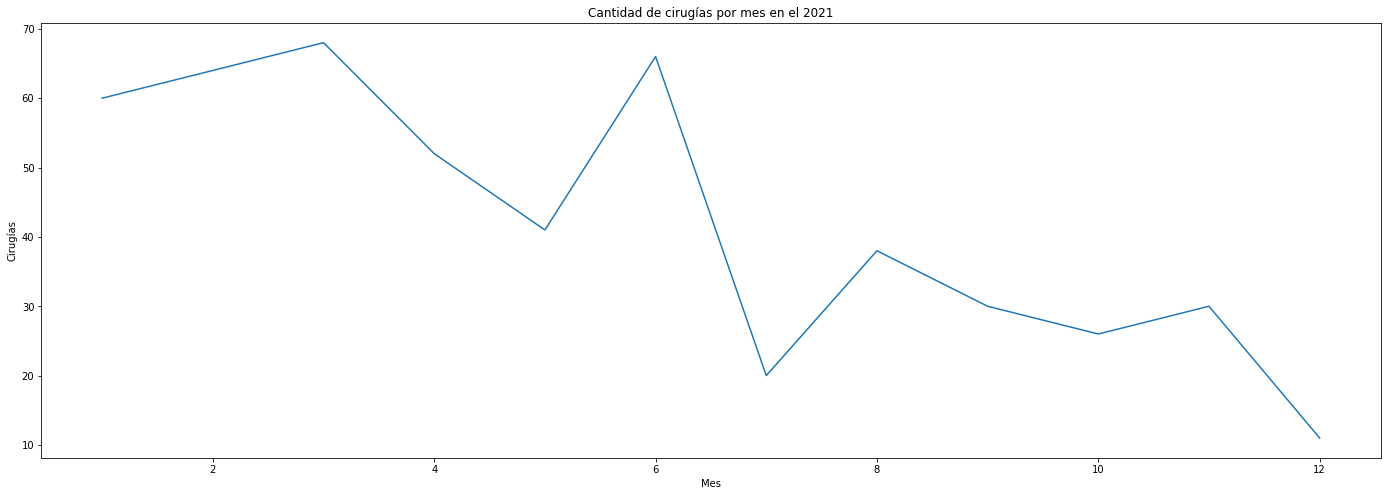

In [ ]:
dfcx5['fecha cirugia'] = pd.to_datetime(dfcx3['fecha cirugia'])
dfcx5['mes'] = dfcx5['fecha cirugia'].dt.month
dfcx21 = dfcx5.drop(dfcx5[dfcx5['year']==2022].index)
cirugiasmes = pd.DataFrame(dfcx21['cantidad de cirugias'].groupby(dfcx21['mes']).sum())
cirugiasmes.reset_index(inplace=True)
cirugiasmes.plot(x='mes', y='cantidad de cirugias', legend=False, xlabel="Mes", ylabel="Cirugías", title= 'Cantidad de cirugías por mes en el 2021', figsize=(24, 8));

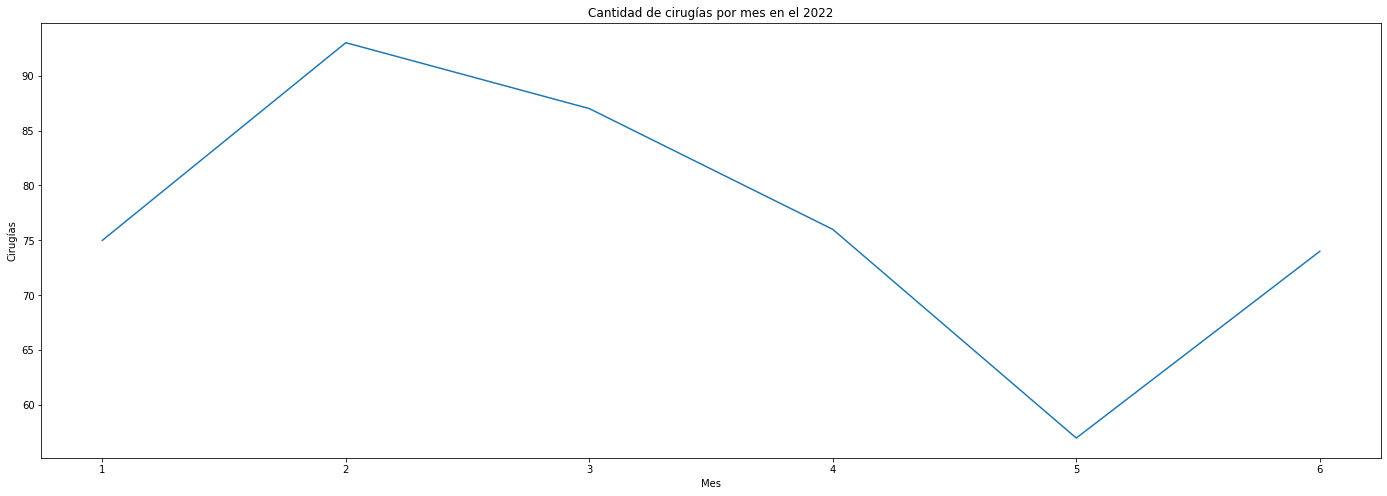

In [ ]:
dfcx22 = dfcx5.drop(dfcx5[dfcx5['year']==2021].index)
dfcx22 = dfcx5.drop(dfcx5[dfcx5['mes']>=7.0].index)
cirugiasmes2 = pd.DataFrame(dfcx22['cantidad de cirugias'].groupby(dfcx22['mes']).sum())
cirugiasmes2.reset_index(inplace=True)
cirugiasmes2.plot(x='mes', y='cantidad de cirugias', legend=False, xlabel="Mes", ylabel="Cirugías", title= 'Cantidad de cirugías por mes en el 2022', figsize=(24, 8));

In [ ]:
base = dfcx5.groupby(['origen admsion'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index().head(5)

# crear gráfica
fig = px.bar(base, x = 'origen admsion', y='nrodoc',
             title= '<b>Origen de Admisión de los pacientes<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Origen Admisión',
    yaxis_title = 'conteo',
    template = 'simple_white',
    title_x = 0.5)

In [ ]:
base = dfcx3.groupby(['sexo'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index()

# crear gráfica
fig = px.pie(base, values = 'nrodoc', names ='sexo',
             title= '<b>Participación de cirugías por Sexo<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [ ]:
base = dfcx3.groupby(['especialidad'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'especialidad', y='nrodoc',
             title= '<b>Tipos de Especialidad (profesionales)<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'especialidad',
    yaxis_title = 'conteo',
    template = 'simple_white',
    title_x = 0.5)

In [ ]:
base = dfcx3.groupby(['categoria complicacion'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index()

# crear gráfica
fig = px.pie(base, values = 'nrodoc', names ='categoria complicacion',
             title= '<b>Categoría de la Complicación<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [ ]:
base = dfcx3.groupby(['ambito según el médico'])[['nrodoc']].count().sort_values('nrodoc', ascending = False).reset_index()

# crear gráfica
fig = px.pie(base, values = 'nrodoc', names ='ambito según el médico',
             title= '<b>Ámbito según el médico<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

# Selección de variables y modelo




Selección de las variables

In [ ]:
# Eliminar variables que no influyen en nuestra variable de interes (cantidad de cirugías)
dfcx3 = dfcx3.drop(['year_x', 'mes_x','fecha recuperacion cx','nrodoc','fecha nacimiento','tipo procedimiento', 'mes_y', 'año',
                   'year_y', 'mes','fecha diligenciamiento', 'hora'],axis=1)
dfcx3['fecha cirugia'] = pd.to_datetime(dfcx3['fecha cirugia'])
dfcx3['mes'] = dfcx3['fecha cirugia'].dt.month

In [ ]:
# Obervar si existen datos nulos.
dfcx3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   cantidad de cirugias                    705 non-null    int64         
 1   codigo servicio habilitacion            705 non-null    float64       
 2   regimen                                 705 non-null    object        
 3   codigo eps                              705 non-null    float64       
 4   fecha orden                             705 non-null    object        
 5   origen orden                            705 non-null    object        
 6   origen admsion                          705 non-null    object        
 7   quirofano                               705 non-null    int64         
 8   fecha cirugia                           705 non-null    datetime64[ns]
 9   tipo de anestesia                       705 non-null  

In [ ]:
# Convertir variableas categóricas en dummies.
dfcx3_dummies = pd.get_dummies(dfcx3,columns=['regimen','origen orden','origen admsion','tipo de anestesia', 'via',
                                              'cod diagnostico prequirurgico','cie 10 tercer caracter', 'capitulo cie10','cod diagnostico postquirurgico',
                                              'tipo de herida', 'tipo aislamiento','especialidad', 'sede','sexo','requiere cita de morbilidad', 'ambito según el médico'])
dfcx3_dummies.shape

(705, 739)

In [ ]:
# Crear matriz de features y target(cantidad de cirugias) 
X = dfcx3_dummies.loc[:,~dfcx3_dummies.columns.isin(['cantidad de cirugias', 'fecha cirugia','fecha orden','municipio'])]
y = dfcx3_dummies['cantidad de cirugias']
y = y.astype('float64')

In [ ]:
# Modelos candidatos, teniendo en cuenta que es un problema de regresión.
m_lreg = linear_model.LinearRegression()
m_rtree=tree.DecisionTreeRegressor()
m_rf= RandomForestRegressor()
m_gbt=GradientBoostingRegressor()

In [ ]:
# Se crea una lista con los anteriores modelos.
modelos=list([m_lreg,m_rtree, m_rf, m_gbt])

In [ ]:
#Se crea una función para determinar que variables se van a elegir, teniendo en cuenta la lista anteriormente mencionada.
def sel_variables(modelos,X,y, SelectFromModel,np,threshold):
    
    var_names_ac=np.array([])
    for modelo in modelos:
        #modelo=modelos[i]
        modelo.fit(X,y)
        sel = SelectFromModel(modelo, prefit=True,threshold=threshold)
        var_names= sel.get_feature_names_out(modelo.feature_names_in_)
        var_names_ac=np.append(var_names_ac, var_names)
        var_names_ac=np.unique(var_names_ac)
    
    return var_names_ac

In [ ]:
# Variables seleccionadas, en este caso se trabajarán con 118.
var_names = sel_variables(modelos, X, y, SelectFromModel, np, threshold="3*mean")
var_names.shape

(118,)

In [ ]:
# Nombres de las variables seleccionadas.
var_names

array(['admision', 'ambito según el médico_Ambulatorio', 'atención',
       'cantidad de registros en cronicos',
       'cantidad de registros en el sistema', 'capitulo cie10_E00-E90',
       'capitulo cie10_I00-I99', 'capitulo cie10_K00-K93',
       'capitulo cie10_V01-Y98', 'cie 10 tercer caracter_E10',
       'cie 10 tercer caracter_E11', 'cie 10 tercer caracter_E13',
       'cie 10 tercer caracter_E21', 'cie 10 tercer caracter_E88',
       'cie 10 tercer caracter_I71', 'cie 10 tercer caracter_K00',
       'cie 10 tercer caracter_K04', 'cie 10 tercer caracter_K05',
       'cie 10 tercer caracter_K11', 'cie 10 tercer caracter_K40',
       'cie 10 tercer caracter_K43', 'cie 10 tercer caracter_K64',
       'cie 10 tercer caracter_K65', 'cie 10 tercer caracter_K80',
       'cie 10 tercer caracter_K82', 'cie 10 tercer caracter_L03',
       'cie 10 tercer caracter_M50', 'cie 10 tercer caracter_M75',
       'cie 10 tercer caracter_M86', 'cie 10 tercer caracter_N84',
       'cie 10 tercer c

In [ ]:
# Matriz con variables seleccionadas
X2 = X[var_names] 

Selección del modelo

In [ ]:
# Se crea una función para poder elegir el mejor modelo de los 4 anteriormente mencionados.
def medir_modelos(modelos,scoring,X,y,cv,cross_val_score,pd):

    metric_modelos=pd.DataFrame()
    for modelo in modelos:
        scores=cross_val_score(modelo,X,y, scoring=scoring, cv=cv )
        pdscores=pd.DataFrame(scores)
        metric_modelos=pd.concat([metric_modelos,pdscores],axis=1)
    
    metric_modelos.columns=["reg_lineal","decision_tree","random_forest","gradient_boosting"]
    return metric_modelos

In [ ]:
# Se analiza el mape y rmse para definir el mejor modelo.
mape_varsel= medir_modelos(modelos,"neg_mean_absolute_percentage_error",X2,y,10, cross_val_score, pd)
rmse_varsel= medir_modelos(modelos,"neg_root_mean_squared_error",X2,y,10, cross_val_score, pd)

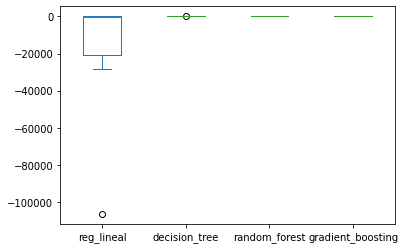

In [ ]:
mape_varsel.plot(kind='box')

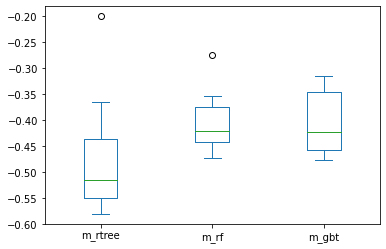

In [ ]:
# De la anterior gráfica no se observa muy bien el comportamiento de los últimos 3 modelos debido a que el primero (Linear Regresor) tiene una gran variación.
# Se elimina dicho modelo, para observar el comportamiento de los otros 3.
modelos2=list([m_rtree, m_rf, m_gbt])
def medir_modelos(modelos2,scoring,X,y,cv,cross_val_score,pd):

    metric_modelos=pd.DataFrame()
    for modelo in modelos2:
        scores=cross_val_score(modelo,X,y, scoring=scoring, cv=cv )
        pdscores=pd.DataFrame(scores)
        metric_modelos=pd.concat([metric_modelos,pdscores],axis=1)
    
    metric_modelos.columns=["m_rtree","m_rf","m_gbt"]
    return metric_modelos

score22 = medir_modelos(modelos2,"neg_mean_absolute_percentage_error",X2,y,10, cross_val_score, pd)

score22.columns=['m_rtree', 'm_rf', 'm_gbt']
score22.plot(kind='box')

#seleccionamos RandomForestRegressor

# Afinamiento de hiperparámetros y evaluación del modelo

In [ ]:
# Hiperparametros
param_grid = [{'n_estimators': [3, 500, 100], 'max_features': [5,20]},
{'bootstrap': [False,True]}]


tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=8,scoring="neg_root_mean_squared_error")
tun_rf.fit(X2,y)

resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]]

rf_final=tun_rf.best_estimator_ ### Guardar el modelo con hyperparameter tunning
m_lreg=m_lreg.fit(X2,y)


In [ ]:
pd_resultados[["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 3, 'max_features': 5}",-1.279621
1,"{'n_estimators': 500, 'max_features': 5}",-1.088357
2,"{'n_estimators': 100, 'max_features': 5}",-1.088084
3,"{'n_estimators': 3, 'max_features': 20}",-1.305086
4,"{'n_estimators': 500, 'max_features': 20}",-1.094755
5,"{'n_estimators': 100, 'max_features': 20}",-1.107883
6,{'bootstrap': False},-1.338100
7,{'bootstrap': True},-1.131552


In [ ]:
eval =cross_validate(rf_final,X2,y,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)

In [ ]:
train_rf=pd.DataFrame(eval['train_score'])
test_rf=pd.DataFrame(eval['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']

In [ ]:
train_test_rf["test_score"].mean()

-1.0918748101006217

In [ ]:
predictions=cross_val_predict(m_lreg,X2,y,cv=5)
predictions.shape

(705,)

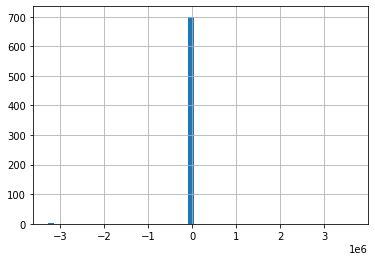

In [ ]:
pred=pd.DataFrame(predictions,columns=['pred'])
pdy=y.to_frame()
error=pdy['cantidad de cirugias']-pred['pred']
error.hist(bins=50)

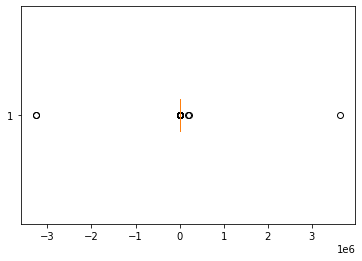

In [ ]:
plt.boxplot(error,vert=False)
plt.show()

In [ ]:
#Evaluación de overfitting y underfitting
results = cross_validate(rf_final,X2,y,return_train_score=True,cv=5) 
results
test_scores = results['test_score']
train_scores = results['train_score']
#score de entrenamiento
print(np.mean(train_scores)) 
#score de prueba
print(np.mean(test_scores))

0.8839674337152879
0.15864697782270362


In [ ]:
# Mirar importancia de variables para tomar acciones

importancia1=pd.DataFrame( m_lreg.feature_names_in_)
importancia2=pd.DataFrame(m_lreg.coef_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]


importancia.sort_values(by=["peso"])

,variable,peso
111,tipo de herida_sin informe quirurgico,-1.513551e+06
17,cie 10 tercer caracter_K05,-1.121652e+06
38,cod diagnostico postquirurgico_E881,-1.121468e+06
57,cod diagnostico prequirurgico_E881,-1.121468e+06
13,cie 10 tercer caracter_E88,-1.121457e+06
...,...,...
55,cod diagnostico postquirurgico_Y838,4.729915e+05
31,cie 10 tercer caracter_Y83,4.729921e+05
58,cod diagnostico prequirurgico_I714,6.306403e+05
39,cod diagnostico postquirurgico_I714,6.306404e+05


In [ ]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
                                        X2,
                                        y,
                                        random_state = 123)

In [ ]:
#Dataframe con las variables influyentes
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': rf_final.feature_importances_})
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
105,talla,0.043633
85,idcx,0.042156
0,admision,0.038572
89,mets -índice metabólico,0.031711
99,presión arterial sistólica,0.031018
...,...,...
24,cie 10 tercer caracter_K82,0.000005
16,cie 10 tercer caracter_K04,0.000004
39,cod diagnostico postquirurgico_I714,0.000003
60,cod diagnostico prequirurgico_K044,0.000000


# Despliegue del modelo

In [ ]:
# Conocer la cantidad de predicciones.
pd_pred = pd.DataFrame(predictions[:705])
pd_pred.shape

(705, 1)

In [ ]:
# Renombrar las predicciones
df = pd_pred
df.columns

RangeIndex(start=0, stop=1, step=1)

In [ ]:
# Redondear para obtener un número entero.
df = df.round()

In [ ]:
# Renombrar la columna de predicción.
df1 = df.rename(columns={'0':'Cantidad de Cirugias predicción'},inplace=True)
df1

In [ ]:
# Traer el ID de los pacientes.
ID = dfcx2["nrodoc"]
ID = pd.DataFrame(ID).reset_index()
ID = ID.drop(["index"],axis=1)

In [ ]:
df.columns=["Cantidad de Cirugias pronosticadas"]
df

,Cantidad de Cirugias pronosticadas
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0
...,...
700,1.0
701,1.0
702,2.0
703,1.0


In [ ]:
# Unir la predicción al ID de cada paciente.
perf_pred=pd.concat([ID,df],axis=1)
perf_pred

,nrodoc,Cantidad de Cirugias pronosticadas
0,306221,1.0
1,306230,2.0
2,306233,1.0
3,306259,1.0
4,306271,2.0
...,...,...
700,314120,1.0
701,314125,1.0
702,314172,2.0
703,314182,1.0
